In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MaxNLocator
import matplotlib.ticker as ticker
import gymnasium as gym
import math
import mlflow
from mlflow.tracking import MlflowClient
import optuna
import os
from scipy.ndimage import gaussian_filter1d
import pandas as pd
from algorithms import *
from model_functions import *
from policy_utils import *
from experiment_result_utils import *
from constants import *
np.random.seed(constants.SEEDS[3])
import matplotlib.image as mpimg

In [2]:

nrows = 30
num_bins = 0
experiment_name = f"FrozenLake_{nrows}x{nrows}_{num_bins}"
path = f"experiments/{experiment_name}"
if not os.path.exists(path):
    os.makedirs(path)

mlflow.set_tracking_uri(MLFLOW_URI)
experiment_id = get_or_create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)


<Experiment: artifact_location='mlflow-artifacts:/180451139397539510', creation_time=1717491409923, experiment_id='180451139397539510', last_update_time=1717491409923, lifecycle_stage='active', name='FrozenLake_30x30_0', tags={}>

In [3]:
results = get_parent_artifacts(experiment_id=experiment_id)
results = sorted(results, key=lambda x: x["label"])

[<Run: data=<RunData: metrics={}, params={}, tags={'mlflow.runName': 'CurrMPI_0',
 'mlflow.source.name': '/Users/cris/opt/anaconda3/envs/mac_env_py310/lib/python3.10/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'cris'}>, info=<RunInfo: artifact_uri='mlflow-artifacts:/180451139397539510/87cbf0417d454ae28a39c1b8c89975d2/artifacts', end_time=None, experiment_id='180451139397539510', lifecycle_stage='active', run_id='87cbf0417d454ae28a39c1b8c89975d2', run_name='CurrMPI_0', run_uuid='87cbf0417d454ae28a39c1b8c89975d2', start_time=1720166835031, status='RUNNING', user_id='cris'>, inputs=<RunInputs: dataset_inputs=[]>>, <Run: data=<RunData: metrics={}, params={}, tags={'mlflow.runName': 'CurrMPI_0',
 'mlflow.source.name': '/Users/cris/opt/anaconda3/envs/mac_env_py310/lib/python3.10/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'cris'}>, info=<RunInfo: artifact_uri='mlflow-artifacts:/180451139397539510/6b5330a18a72

Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmpxz8s2j14\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=1909408, is_dir=False, path='results.pth'>, <FileInfo: file_size=28990, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmp42wxpois\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=1968224, is_dir=False, path='results.pth'>, <FileInfo: file_size=29346, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmpw46r9v0j\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=4226272, is_dir=False, path='results.pth'>, <FileInfo: file_size=30523, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmpur5802vb\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=1175136, is_dir=False, path='results.pth'>, <FileInfo: file_size=29317, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmpjt4lxazs\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=1309472, is_dir=False, path='results.pth'>, <FileInfo: file_size=25339, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmpjyzfw_f8\results.pth
Dictionary loaded from MLflow


In [4]:
"""results[3]["label"] = '2'"""

'results[3]["label"] = \'2\''

In [5]:
print(results[0].keys())

dict_keys(['tests_returns', 'taus', 'tests_lens', 'num_runs', 'change_map', 'num_bins', 'label', 'checkpoint_step'])


In [6]:
def plot_experiment_results(results, title=None, figsize=(6, 6), 
                            reduce=False, extend=False,
                            conf_int=False, 
                            x_len_ticks=2, log_scale=False, 
                            moving_avg_window=1, ci_ma=1,
                            focus_range=None):
    assert x_len_ticks >= 2, "Error: x_len_ticks must be >= than 2" 
    plt.close('all')
    optimal = None
    rew = [r["tests_returns"] for r in results]
    reduced_len = np.min([len(r[0]) for r in rew])
    reduced_len = int(reduced_len * 1.2)
    max_len = np.max([len(r[0]) for r in rew])
    fig, ax = plt.subplots(figsize=figsize)

    title = "Average Return" if title is None else title
    for i, result in enumerate(results):
        rewards = result["tests_returns"]
        label = result["label"]
        if "CurrQ" in label:
            optimal = rewards[0][-1]
        avg_rewards = np.mean(rewards, axis=0)
        if reduce:
            avg_rewards = avg_rewards[:reduced_len]
        
        # Calculate moving average
        if moving_avg_window > 1:
            avg_rewards = pd.Series(avg_rewards).rolling(window=moving_avg_window, min_periods=1).mean().values

        current_x_scale = result["checkpoint_step"]
        x_values = np.arange(len(avg_rewards)) * current_x_scale
        
        if log_scale:
            ax.set_xscale('log')
            ax.plot(x_values, avg_rewards, label=LABEL_DICT[label], c=COLORS_DICT[label], 
                    linestyle=LINE_STYLES_DICT[label],
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_LOG_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label])
        else:
            ax.plot(x_values, avg_rewards, label=LABEL_DICT[label], c=COLORS_DICT[label],
                    linestyle=LINE_STYLES_DICT[label], 
                    marker=MARKERS_DICT[label],
                    markevery=MARKER_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label])
        
        if conf_int:
            std_dev = np.std(rewards, axis=0)
            if reduce:
                std_dev = std_dev[:reduced_len]
            
            n_samples = len(rewards)
            if moving_avg_window > 1:
                std_dev = pd.Series(std_dev).rolling(window=moving_avg_window, min_periods=1).mean().values
            std_err = std_dev / np.sqrt(n_samples)
            ci = 1.96
            upper_bound = avg_rewards + ci * std_err
            lower_bound = avg_rewards - ci * std_err
            plt.fill_between(x_values, lower_bound, upper_bound, color=COLORS_DICT[label], alpha=0.2)
    
    if optimal is not None:
        optimal_label = 'Optimal'
        ax.axhline(y=optimal, color=COLORS_DICT[optimal_label], 
                   linestyle=LINE_STYLES_DICT[optimal_label], 
                   label=optimal_label)
        ax.set_yticks(adjust_y_ticks(ax, optimal))
    
    length = max_len if not reduce else reduced_len
    length = length * current_x_scale
    
    if not log_scale:
        xticks_labels = generate_uniform_labels(0, length)
        ax.set_xticks(np.linspace(0, length, len(xticks_labels))) # Evenly spaced ticks
        ax.set_xticklabels(xticks_labels)
    else:
        if focus_range:
            ax.set_xlim(focus_range)
    
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_xlabel('Episodes', fontsize=20)
    ax.set_ylabel('Average Return', fontsize=20)
    ax.set_title(title, fontsize=20)
    #ax.legend(loc="best", framealpha=1.)
    plt.show()
    return fig

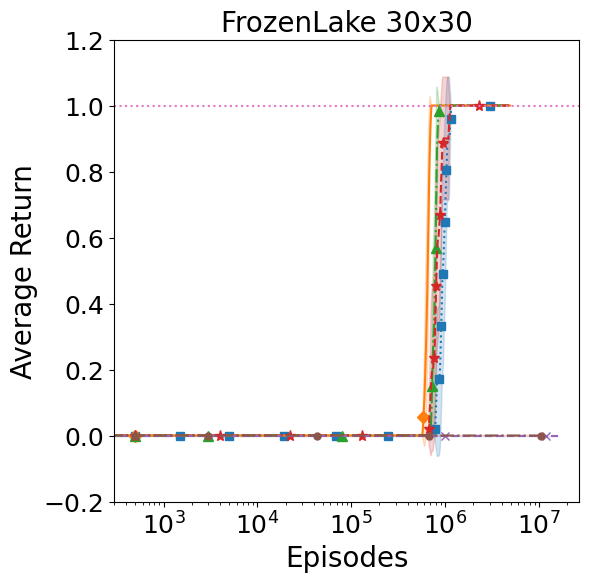

In [7]:
parts = experiment_name.split("_")
if len(parts) == 3:
    title = f"{parts[0]} {parts[1]}, {parts[2]} Reward bins"
    if parts[2] == "0":
        title = f"{parts[0]} {parts[1]}"

else:
    title = f"{parts[0]} {parts[1]}"

focus_range=(6*10**4, 7*10**6)
fig = plot_experiment_results(results, reduce=False, conf_int=True, 
                              x_len_ticks=4, title=title,
                              log_scale=True, moving_avg_window=100, focus_range=None)

fig.savefig(f"{path}/avg_return_{experiment_name}.png", bbox_inches='tight', dpi=1000)

In [8]:
def plot_experiment_len(results, title=None, figsize=(6, 6), 
                            reduce:bool=False, extend:bool=False,
                            conf_int:bool=False,
                            x_len_ticks:int=2, log_scale:bool=False, 
                            ci_ma:int=1, moving_avg_window:int=1,
                            sample_step:int=1,):
    assert x_len_ticks >= 2, "Error: x_len_ticks must be >= than 2" 
    plt.close('all')
    optimal = None
    rew = [r["tests_returns"] for r in results if r.get("label") != "PPO"]
    reduced_len = np.min([len(r[0]) for r in rew])
    max_len = np.max([len(r[0]) for r in rew])
    fig, ax = plt.subplots(figsize=figsize)
    
    title = r"Average Episode Length" if title is None else title
    for i, result in enumerate(results):
        if result.get("tests_lens") is None:
            print(f"Skipping {result['label']}")
            continue
        tests_lens = result["tests_lens"]
        label = result["label"]
        if label == "PPO" and num_bins == 0:
            tests_lens = results[5]["tests_lens"]
        optimal = 2*nrows-2
        avg_tests_lens = np.mean(tests_lens, axis=0)[::sample_step]
        if reduce:
            avg_tests_lens = avg_tests_lens[:reduced_len]

        if moving_avg_window > 1:
            avg_tests_lens = pd.Series(avg_tests_lens).rolling(window=moving_avg_window, min_periods=1).mean().values
        
        if label == "PPO" and num_bins == 0:
            current_x_scale = results[5]["checkpoint_step"]
        else:
            current_x_scale = result["checkpoint_step"]*sample_step
        x_values = np.arange(len(avg_tests_lens)) * current_x_scale
        
        if log_scale:
            ax.set_xscale('log')
            ax.plot(x_values, avg_tests_lens, label=LABEL_DICT[label], c=COLORS_DICT[label], 
                    linestyle=LINE_STYLES_DICT[label],
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_LOG_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        else:
            ax.plot(x_values, avg_tests_lens, label=LABEL_DICT[label], c=COLORS_DICT[label],
                    linestyle=LINE_STYLES_DICT[label], 
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        
        if conf_int:
            std_dev = np.std(tests_lens, axis=0)[::sample_step]
            if reduce:
                std_dev = std_dev[:reduced_len]
            
            n_samples = len(tests_lens)
            if moving_avg_window > 1:
                std_dev = pd.Series(std_dev).rolling(window=moving_avg_window, min_periods=1).mean().values
            std_err = std_dev / np.sqrt(n_samples)
            ci = 1.96
            upper_bound = avg_tests_lens + ci * std_err
            lower_bound = avg_tests_lens - ci * std_err
            plt.fill_between(x_values, lower_bound, upper_bound, color=COLORS_DICT[label], alpha=0.2)
    
    if optimal is not None:
        optimal_label = 'Optimal'
        ax.axhline(y=optimal, color=COLORS_DICT[optimal_label], 
                   linestyle=LINE_STYLES_DICT[optimal_label], 
                   label=optimal_label)
        ax.set_yticks(adjust_y_ticks(ax, optimal))
    
    length = max_len if not reduce else reduced_len
    length = length * current_x_scale
    ax.legend(loc="best", framealpha=1.)
    
    if not log_scale:
        xticks_labels = generate_uniform_labels(0, length)
        ax.set_xticks(np.linspace(0, length, len(xticks_labels))) # Evenly spaced ticks
        ax.set_xticklabels(xticks_labels)
    
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_xlabel('Episodes', fontsize=20)
    ax.set_ylabel('Episode Length', fontsize=20)
    ax.set_title(title, fontsize=20)
    plt.show()
    return fig

In [9]:
MARKER_LOG_FREQUENCY_DICT = {
    'CurrMPI': 0.12988500, 
    'CurrPMPO': 0.14752317, 
    'CurrPPO': 0.2160360, 
    'CurrQ': 0.1371094, 
    'PPO': 0.1503189, 
    'Q': 0.227748,
    'Optimal': 0.680003,
    '2': 0.68
}

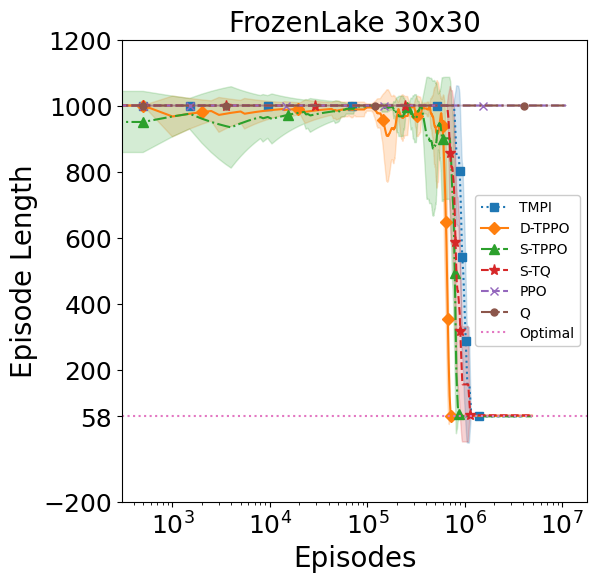

In [10]:
fig = plot_experiment_len(results, reduce=False, title=title,
                              log_scale=True, conf_int=True, 
                              moving_avg_window=100, sample_step=1)
fig.savefig(f"{path}/avg_ep_len_{experiment_name}.png", bbox_inches='tight', dpi=1000)

In [11]:
def plot_experiment_taus(results, title=None, figsize=(6, 6), 
                            reduce:bool=False, extend:bool=False,
                            conf_int:bool=False,
                            x_len_ticks:int=2, log_scale:bool=False, 
                            ci_ma:int=1, moving_avg_window:int=1,
                            sample_step:int=1,):
    assert x_len_ticks >= 2, "Error: x_len_ticks must be >= than 2" 
    plt.close('all')
    rew = [r["tests_returns"] for r in results if r.get("label") != "PPO" and r.get("label") != "Q"]

    reduced_len = np.min([len(r[0]) for r in rew])
    reduced_len = int(reduced_len * 1.4)
    max_len = np.max([len(r[0]) for r in rew])
    fig, ax = plt.subplots(figsize=figsize)
    title = r"Average $\tau$" if title is None else title
    curr_q_index = results.index([r for r in results if r.get("label") == "CurrQ"][0])
    for i, result in enumerate(results):
        label = result["label"]
        if label == 'PPO' or label == 'Q':
            taus = np.zeros_like(results[curr_q_index]["taus"])
        else:
            taus = np.array(result["taus"])
        if taus.ndim == 1:
            taus = taus[None, :]
        
        avg_taus = np.mean(taus, axis=0)[::sample_step]
        if reduce:
            avg_taus = avg_taus[:reduced_len]
        
        if moving_avg_window > 1:
            avg_taus = pd.Series(avg_taus).rolling(window=moving_avg_window, min_periods=1).mean().values
        current_x_scale = result["checkpoint_step"] if not label == "PPO" and not label == "Q" else results[curr_q_index]["checkpoint_step"]
        x_values = np.arange(len(avg_taus)) * current_x_scale*sample_step
        if log_scale:
            ax.set_xscale('log')
            ax.plot(x_values, avg_taus, label=LABEL_DICT[label], c=COLORS_DICT[label], 
                    linestyle=LINE_STYLES_DICT[label],
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_LOG_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        else:
            ax.plot(x_values, avg_taus, label=LABEL_DICT[label], c=COLORS_DICT[label],
                    linestyle=LINE_STYLES_DICT[label], 
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        if conf_int:
            std_dev = np.std(taus, axis=0)[::sample_step]
            if reduce:
                std_dev = std_dev[:reduced_len]
            
            n_samples = len(taus)
            if moving_avg_window > 1:
                std_dev = pd.Series(std_dev).rolling(window=moving_avg_window, min_periods=1).mean().values
            std_err = std_dev / np.sqrt(n_samples)
            ci = 1.96
            upper_bound = avg_taus + ci * std_err
            lower_bound = avg_taus - ci * std_err
            plt.fill_between(x_values, lower_bound, upper_bound, color=COLORS_DICT[label], alpha=0.2)

    length = max_len if not reduce else reduced_len
    length = length * current_x_scale
    if not log_scale:
        xticks_labels = generate_uniform_labels(0, length)
        ax.set_xticks(np.linspace(0, length, len(xticks_labels))) # Evenly spaced ticks
        ax.set_xticklabels(xticks_labels)
        
    
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_xlabel('Episodes', fontsize=20)
    ax.set_ylabel(r'Average $\tau$', fontsize=20)
    ax.set_title(title, fontsize=20)
    #ax.legend(loc="best", framealpha=1.)
    plt.show()
    return fig

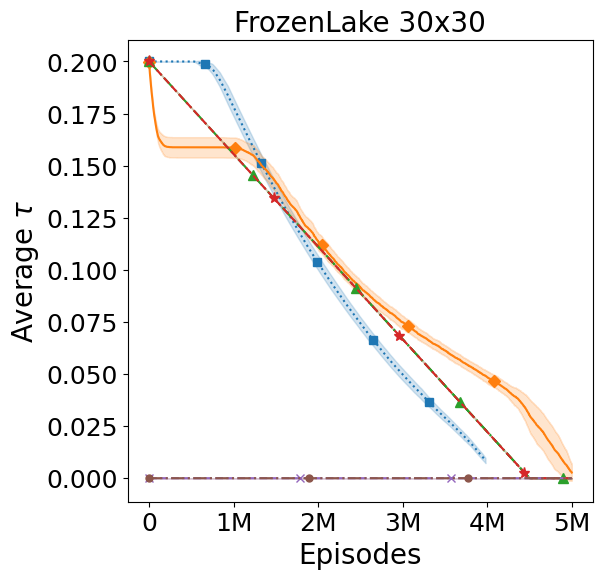

In [12]:
fig = plot_experiment_taus(results, reduce=False, 
                              x_len_ticks=4, title=title,
                              log_scale=False, conf_int=True, 
                              moving_avg_window=1, sample_step=1)
fig.savefig(f"{path}/avg_tau_{experiment_name}.png", bbox_inches='tight', dpi=1000)

In [13]:
def plot_experiment_gamma_eff(results, title=None, figsize=(6, 6), 
                            reduce:bool=False, extend:bool=False,
                            conf_int:bool=False, 
                            x_len_ticks:int=2, log_scale:bool=False, 
                            ci_ma:int=1, moving_avg_window:int=1,
                            sample_step:int=1,):
    assert x_len_ticks >= 2, "Error: x_len_ticks must be >= than 2" 
    plt.close('all')
    rew = [r["tests_returns"] for r in results if r.get("label") != "PPO" and r.get("label") != "Q"]
    reduced_len = np.min([len(r[0]) for r in rew])
    reduced_len = int(reduced_len * 1.4)
    max_len = np.max([len(r[0]) for r in rew])
    fig, ax = plt.subplots(figsize=figsize)
    title = r"Average $\tau$" if title is None else title
    curr_q_index = results.index([r for r in results if r.get("label") == "CurrQ"][0])
    for i, result in enumerate(results):
        label = result["label"]
        gamma = 0.99
        if label == 'PPO' or label == 'Q':
            taus = np.zeros_like(results[curr_q_index]["taus"])
        else:
            taus = np.array(result["taus"])
        if taus.ndim == 1:
            taus = taus[None, :]

        gamma_eff = (1-taus)*gamma
        avg_gamma_eff = np.mean(gamma_eff, axis=0)[::sample_step]
        if reduce:
            avg_gamma_eff = avg_gamma_eff[:reduced_len]
        current_x_scale = result["checkpoint_step"] if not label == "PPO" and not label == "Q" else results[curr_q_index]["checkpoint_step"]
        x_values = np.arange(len(avg_gamma_eff)) * current_x_scale*sample_step
        
        if log_scale:
            ax.set_xscale('log')
            ax.plot(x_values, avg_gamma_eff, label=LABEL_DICT[label], c=COLORS_DICT[label], 
                    linestyle=LINE_STYLES_DICT[label],
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_LOG_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        else:
            ax.plot(x_values, avg_gamma_eff, label=LABEL_DICT[label], c=COLORS_DICT[label],
                    linestyle=LINE_STYLES_DICT[label], 
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        if conf_int:
            std_dev = np.std(gamma_eff, axis=0)[::sample_step]
            if reduce:
                std_dev = std_dev[:reduced_len]
            
            n_samples = len(gamma_eff)
            if moving_avg_window > 1:
                std_dev = pd.Series(std_dev).rolling(window=moving_avg_window, min_periods=1).mean().values
            std_err = std_dev / np.sqrt(n_samples)
            ci = 1.96
            upper_bound = avg_gamma_eff + ci * std_err
            lower_bound = avg_gamma_eff - ci * std_err
            plt.fill_between(x_values, lower_bound, upper_bound, color=COLORS_DICT[label], alpha=0.2)

    length = max_len if not reduce else reduced_len
    length = length * current_x_scale
    ax.legend(loc="best", framealpha=1.)
    ax.set_title(title)
    if not log_scale:
        xticks_labels = generate_uniform_labels(0, length)
        ax.set_xticks(np.linspace(0, length, len(xticks_labels))) # Evenly spaced ticks
        ax.set_xticklabels(xticks_labels)
        
    ax.set_xlabel('Episodes', fontsize=16)
    ax.set_ylabel(r'Average $\gamma_{eff}$', fontsize=16)
    plt.show()
    return fig

In [14]:
MARKER_LOG_FREQUENCY_DICT = {
    'CurrMPI': 0.08, 
    'CurrPMPO': 0.25, 
    'CurrPPO': 0.17, 
    'CurrQ': 0.11, 
    'PPO': 0.17, 
    'Q': 0.19,
    'Optimal': 0.68,
    '2': 0.68
}

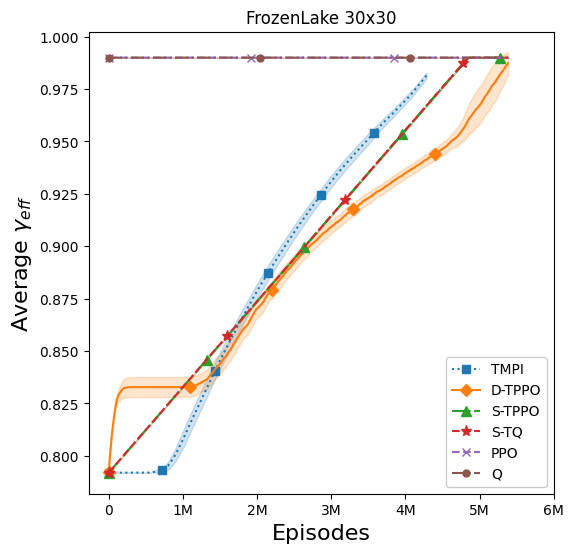

In [15]:
fig = plot_experiment_gamma_eff(results, reduce=True, 
                              x_len_ticks=4, title=title,
                              log_scale=False, conf_int=True, 
                              moving_avg_window=100, sample_step=1)
fig.savefig(f"{path}/avg_gamma_eff_{experiment_name}.png", bbox_inches='tight', dpi=1000)

In [16]:
"""base_path = "experiments"
env_name = "FrozenLake_30x30"
bins = [15, 10, 7, 3, 1, 0]
avg_ret = "avg_return"
avg_gamma_eff = "avg_gamma_eff"
avg_ep_len = "avg_ep_len"
avg_tau = "avg_tau"

avg_ret_images = [mpimg.imread(f"{base_path}/{env_name}_{n}/{avg_ret}_{env_name}_{n}.png") for n in bins]
avg_ep_len_images = [mpimg.imread(f"{base_path}/{env_name}_{n}/{avg_ep_len}_{env_name}_{n}.png") for n in bins]
avg_gamma_eff_images = [mpimg.imread(f"{base_path}/{env_name}_{n}/{avg_gamma_eff}_{env_name}_{n}.png") for n in bins]
avg_tau_images = [mpimg.imread(f"{base_path}/{env_name}_{n}/{avg_tau}_{env_name}_{n}.png") for n in bins]
"""

'base_path = "experiments"\nenv_name = "FrozenLake_30x30"\nbins = [15, 10, 7, 3, 1, 0]\navg_ret = "avg_return"\navg_gamma_eff = "avg_gamma_eff"\navg_ep_len = "avg_ep_len"\navg_tau = "avg_tau"\n\navg_ret_images = [mpimg.imread(f"{base_path}/{env_name}_{n}/{avg_ret}_{env_name}_{n}.png") for n in bins]\navg_ep_len_images = [mpimg.imread(f"{base_path}/{env_name}_{n}/{avg_ep_len}_{env_name}_{n}.png") for n in bins]\navg_gamma_eff_images = [mpimg.imread(f"{base_path}/{env_name}_{n}/{avg_gamma_eff}_{env_name}_{n}.png") for n in bins]\navg_tau_images = [mpimg.imread(f"{base_path}/{env_name}_{n}/{avg_tau}_{env_name}_{n}.png") for n in bins]\n'

In [17]:
"""import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Assuming avg_ret_images and avg_ep_len_images are already defined and are numpy arrays

# Create the figure
fig = plt.figure(figsize=(12, 16))  # Adjust the figsize to your needs

# Create a GridSpec with the desired number of rows and columns
gs = GridSpec(3, 2, figure=fig, wspace=0.02, hspace=0.02)  # Adjust wspace and hspace as needed

# Plot the images
for i in range(3):
    ax1 = fig.add_subplot(gs[i, 0])
    ax1.imshow(avg_ret_images[i], aspect='auto')  # Set aspect to 'auto'
    ax1.axis('off')
    ax1.set_aspect('equal')  # Ensure the aspect ratio is equal

    ax2 = fig.add_subplot(gs[i, 1])
    ax2.imshow(avg_ep_len_images[i], aspect='auto')  # Set aspect to 'auto'
    ax2.axis('off')
    ax2.set_aspect('equal')  # Ensure the aspect ratio is equal


# Adjust layout to reduce the space between images
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.02, hspace=0.02)

# Save the figure
fig.savefig('experiments/FrozenLake_ret_len_1.png', bbox_inches='tight', pad_inches=0.1, dpi=1000)

# Show the figure
plt.show()
"""

"import matplotlib.pyplot as plt\nfrom matplotlib.gridspec import GridSpec\n\n# Assuming avg_ret_images and avg_ep_len_images are already defined and are numpy arrays\n\n# Create the figure\nfig = plt.figure(figsize=(12, 16))  # Adjust the figsize to your needs\n\n# Create a GridSpec with the desired number of rows and columns\ngs = GridSpec(3, 2, figure=fig, wspace=0.02, hspace=0.02)  # Adjust wspace and hspace as needed\n\n# Plot the images\nfor i in range(3):\n    ax1 = fig.add_subplot(gs[i, 0])\n    ax1.imshow(avg_ret_images[i], aspect='auto')  # Set aspect to 'auto'\n    ax1.axis('off')\n    ax1.set_aspect('equal')  # Ensure the aspect ratio is equal\n\n    ax2 = fig.add_subplot(gs[i, 1])\n    ax2.imshow(avg_ep_len_images[i], aspect='auto')  # Set aspect to 'auto'\n    ax2.axis('off')\n    ax2.set_aspect('equal')  # Ensure the aspect ratio is equal\n\n\n# Adjust layout to reduce the space between images\nplt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.02

In [18]:
"""import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Assuming avg_ret_images and avg_ep_len_images are already defined and are numpy arrays

# Create the figure
fig = plt.figure(figsize=(12, 16))  # Adjust the figsize to your needs

# Create a GridSpec with the desired number of rows and columns
gs = GridSpec(3, 2, figure=fig)  # Adjust wspace and hspace as needed

# Plot the images
for i, j in zip(range(3), range(3,6)):
    ax1 = fig.add_subplot(gs[i, 0])
    ax1.imshow(avg_ret_images[j], aspect='auto')  # Set aspect to 'auto'
    ax1.axis('off')
    ax1.set_aspect('equal')  # Ensure the aspect ratio is equal

    ax2 = fig.add_subplot(gs[i, 1])
    ax2.imshow(avg_ep_len_images[j], aspect='auto')  # Set aspect to 'auto'
    ax2.axis('off')
    ax2.set_aspect('equal')  # Ensure the aspect ratio is equal


# Adjust layout to reduce the space between images
plt.tight_layout()

# Save the figure
fig.savefig('experiments/FrozenLake_ret_len_2.png', bbox_inches='tight', pad_inches=0.1, dpi=1000)

# Show the figure
plt.show()
"""

"import matplotlib.pyplot as plt\nfrom matplotlib.gridspec import GridSpec\n\n# Assuming avg_ret_images and avg_ep_len_images are already defined and are numpy arrays\n\n# Create the figure\nfig = plt.figure(figsize=(12, 16))  # Adjust the figsize to your needs\n\n# Create a GridSpec with the desired number of rows and columns\ngs = GridSpec(3, 2, figure=fig)  # Adjust wspace and hspace as needed\n\n# Plot the images\nfor i, j in zip(range(3), range(3,6)):\n    ax1 = fig.add_subplot(gs[i, 0])\n    ax1.imshow(avg_ret_images[j], aspect='auto')  # Set aspect to 'auto'\n    ax1.axis('off')\n    ax1.set_aspect('equal')  # Ensure the aspect ratio is equal\n\n    ax2 = fig.add_subplot(gs[i, 1])\n    ax2.imshow(avg_ep_len_images[j], aspect='auto')  # Set aspect to 'auto'\n    ax2.axis('off')\n    ax2.set_aspect('equal')  # Ensure the aspect ratio is equal\n\n\n# Adjust layout to reduce the space between images\nplt.tight_layout()\n\n# Save the figure\nfig.savefig('experiments/FrozenLake_ret_le